# Preparación del entorno

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from scipy.interpolate import interp1d

# Procesamiento de datos

## Por sexo

### Cargar datos

In [2]:
file_path = "data/eph/Sexo_concatenado.csv"
sexo = pd.read_csv(file_path)
sexo["Año"] = pd.to_datetime(sexo["Año"], format="%Y")

varon = sexo[sexo["Sexo"] == "Varón"]
mujer = sexo[sexo["Sexo"] == "Mujer"]

### interpolación de datos

In [3]:
varon_2015 = pd.DataFrame({"Año": [pd.to_datetime('2015')], "Sexo": ["Varón"]})
mujer_2015 = pd.DataFrame({"Año": [pd.to_datetime('2015')], "Sexo": ["Mujer"]})

varon = pd.concat([varon, varon_2015])
mujer = pd.concat([mujer, mujer_2015])

varon = varon.sort_values(by="Año").reset_index(drop=True)
mujer = mujer.sort_values(by="Año").reset_index(drop=True)

columnas = sexo.columns[2:]

for columna in columnas:
    valid_varon = varon.dropna(subset=[columna])
    valid_mujer = mujer.dropna(subset=[columna])

    if len(valid_varon) > 1 and len(valid_mujer) > 1:
        varon_interp = interp1d(valid_varon["Año"].astype(
            np.int64), valid_varon[columna], kind='linear', fill_value="extrapolate")
        mujer_interp = interp1d(valid_mujer["Año"].astype(
            np.int64), valid_mujer[columna], kind='linear', fill_value="extrapolate")

        varon[columna] = varon_interp(varon["Año"].astype(np.int64))
        mujer[columna] = mujer_interp(mujer["Año"].astype(np.int64))

sexo = pd.concat([varon, mujer]).sort_values(
    by=["Sexo", "Año"]).reset_index(drop=True)
sexo["Año"] = [año.year for año in pd.to_datetime(sexo["Año"], format="%Y")]
sexo.to_csv("data/eph/Sexo_concatenado_interp.csv", index=False)

## Por región

### Cargar datos

In [4]:
file_path = "data/eph/Region_concatenado.csv"
reg = pd.read_csv(file_path)

DFs = {}
regiones = reg["REGION"].unique()
for region in regiones:
    region_df = reg[reg["REGION"] == region].copy()
    region_df["Año"] = pd.to_datetime(region_df["Año"], format="%Y")
    region_2015 = pd.DataFrame(
        {"Año": [pd.to_datetime('2015', format="%Y")], "REGION": [region]})
    region_df = pd.concat([region_df, region_2015])
    region_df = region_df.sort_values(by="Año").reset_index(drop=True)
    DFs[region] = region_df

### Interpolar de datos

In [5]:
columnas = reg.columns[2:]
for columna in columnas:
    for region in regiones:
        valid = DFs[region].dropna(subset=[columna])
        if len(valid) > 1:
            interp = interp1d(valid["Año"].astype(
                np.int64), valid[columna], kind='linear', fill_value="extrapolate")
            DFs[region][columna] = interp(DFs[region]["Año"].astype(np.int64))

reg_interp = pd.concat(DFs.values()).sort_values(
    by=["REGION", "Año"]).reset_index(drop=True)
reg_interp['Año'] = [año.year for año in pd.to_datetime(
    reg_interp['Año'], format="%Y")]
reg_interp.to_csv("data/eph/Region_concatenado_interp.csv", index=False)

# Generación de gráficos

## General

### Cargar datos y crear carpeta

In [6]:
file_path = "data/eph/General-2015-estimado.csv"
eph = pd.read_csv(file_path)
eph["Año"] = pd.to_datetime(eph["Año"], format="%Y")

os.makedirs("plots/eph/general", exist_ok=True)

años = eph["Año"].dt.year.unique()

actividad = eph['Tasa.Actividad']
actividad.name = 'Actividad'

empleo = eph['Tasa.Empleo']
empleo.name = 'Empleo'

desempleo = eph['Tasa.Desempleo']
desempleo.name = 'Desempleo'

subocupacion = eph['Tasa.Subocupados']
subocupacion.name = 'Subocupacion'

informalidad = eph['Tasa.Informalidad']
informalidad.name = 'Informalidad'

tasas = [actividad, empleo, desempleo, subocupacion, informalidad]

### Gráficos de cada tasa por año

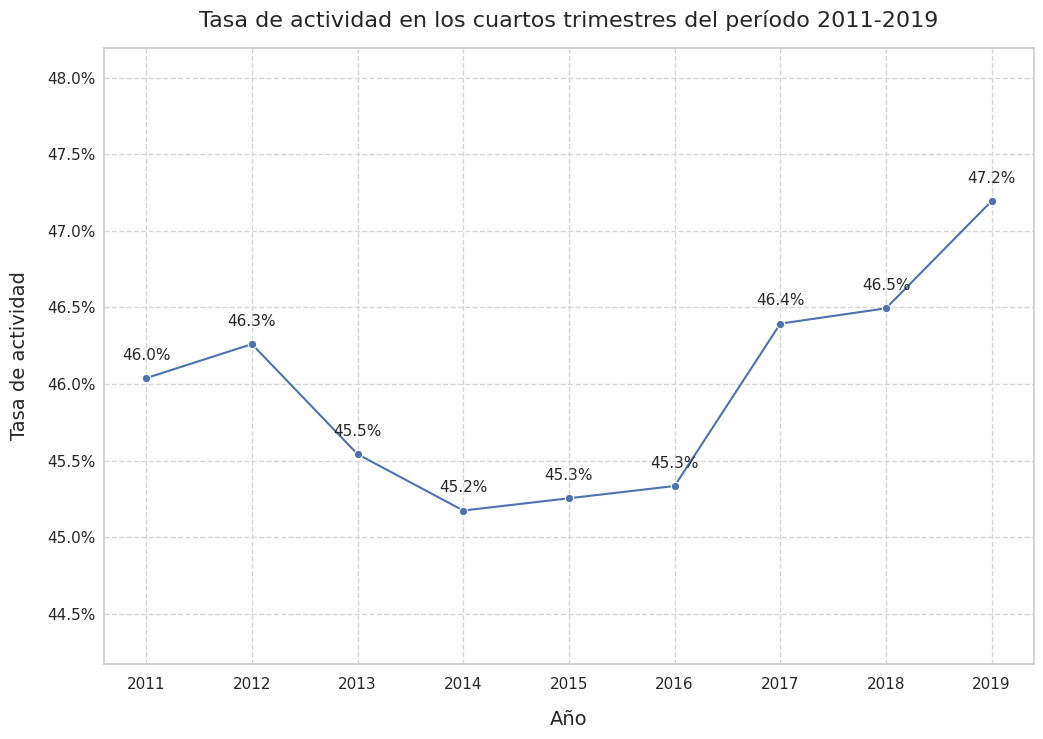

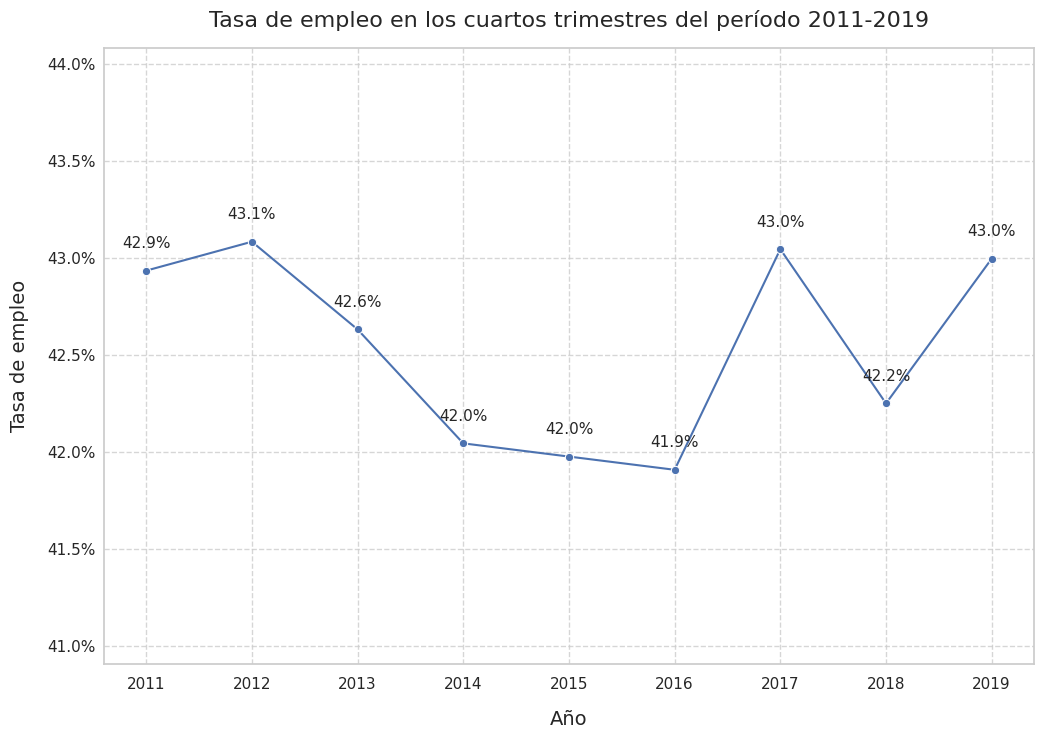

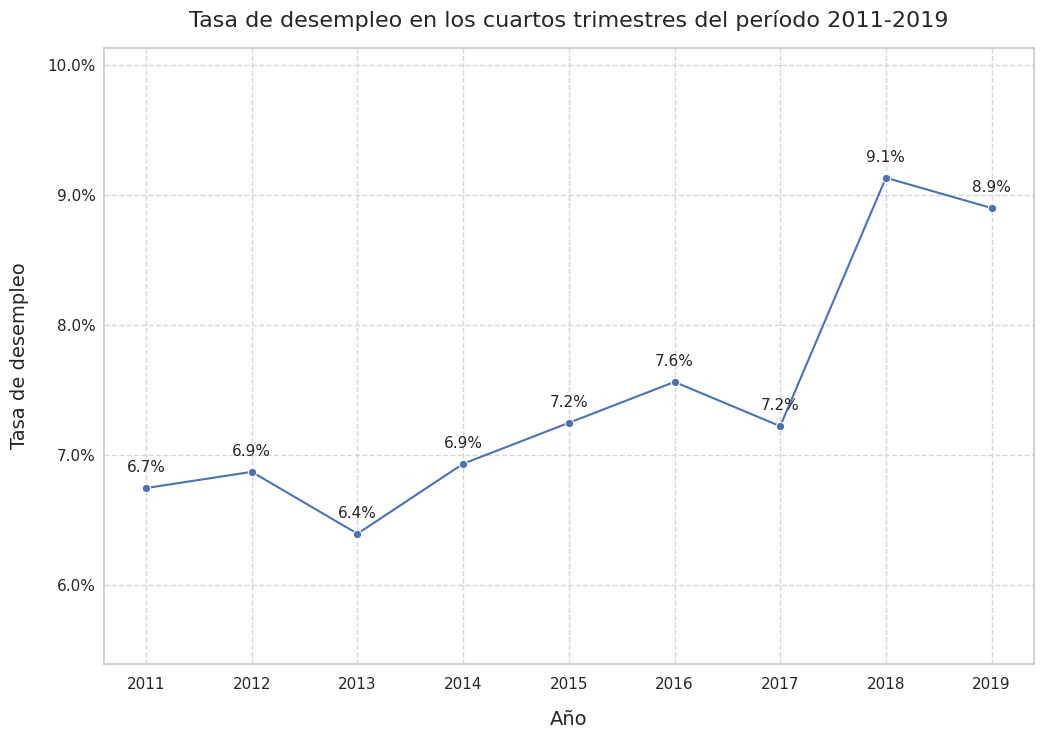

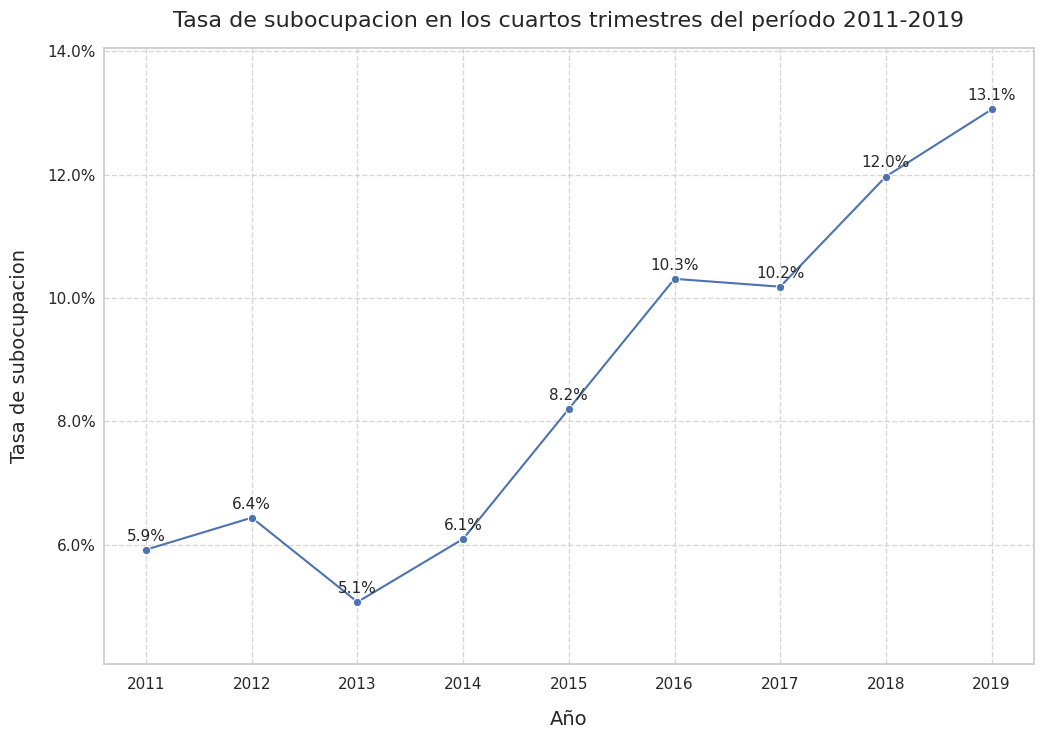

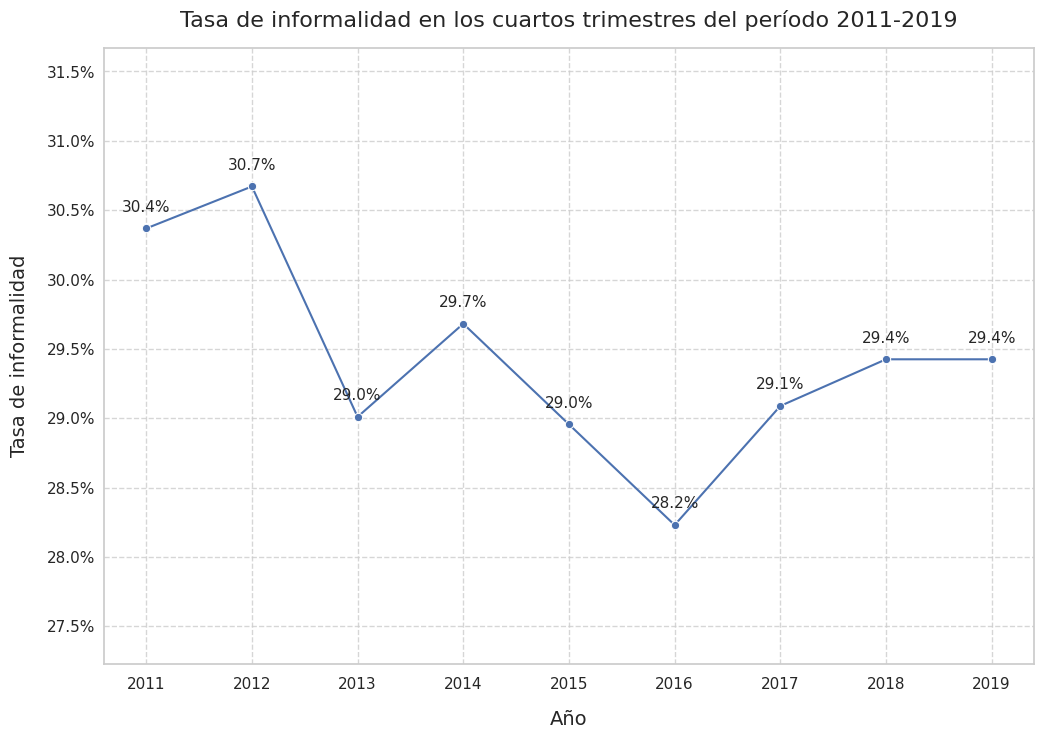

In [19]:
for tasa in tasas:
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(12, 8))
    ax = sns.lineplot(x=años, y=tasa, data=eph, marker='o')
    plt.title(f'Tasa de {
              tasa.name.lower()} en los cuartos trimestres del período 2011-2019', fontsize=16, pad=15)
    plt.grid(True, linestyle='--', alpha=0.8)

    ax.set_xlabel('Año', fontsize=14, labelpad=13)
    ax.set_ylabel(f'Tasa de {tasa.name.lower()}', fontsize=14, labelpad=13)
    ax.set_ylim(min(tasa) - 1, max(tasa) + 1)

    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1f}%'))
    ax.yaxis.set_tick_params(pad=0.05)

    for x, y in zip(años, tasa):
        ax.text(x, y + 0.1, f'{y:.1f}%', ha='center', va='bottom', fontsize=11)

    plt.savefig(f"plots/eph/general/{tasa.name}_general.png")
    plt.show()

## Por sexo

### Cargar datos y crear carpeta

In [8]:
file_path = "data/eph/Sexo_concatenado_interp.csv"
sexo = pd.read_csv(file_path)
sexo["Año"] = pd.to_datetime(sexo["Año"], format="%Y")

varon = sexo[sexo["Sexo"] == "Varón"].copy()
mujer = sexo[sexo["Sexo"] == "Mujer"].copy()

columnas = list(sexo.columns[2:-1])
nombre_columnas = ["Actividad", "Empleo",
                   "Desempleo", "Subocupación", "Informalidad"]
nombre_columnas = dict(zip(columnas, nombre_columnas))

os.makedirs("plots/eph/sexo", exist_ok=True)

### Gráficos de cada tasa por año y sexo

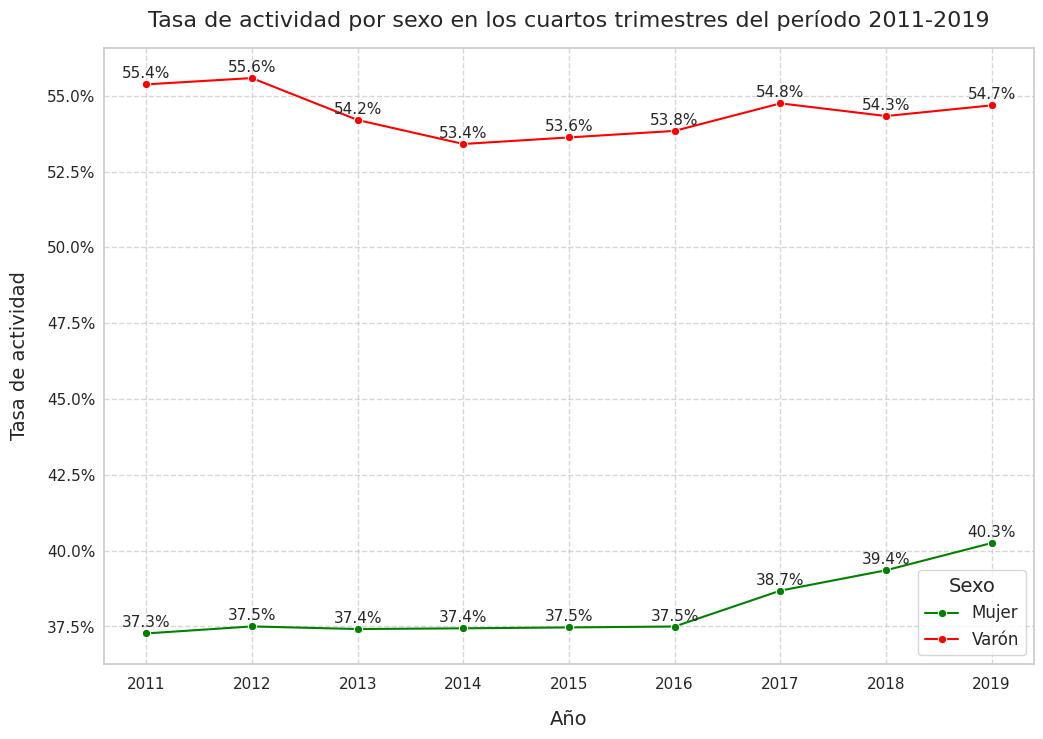

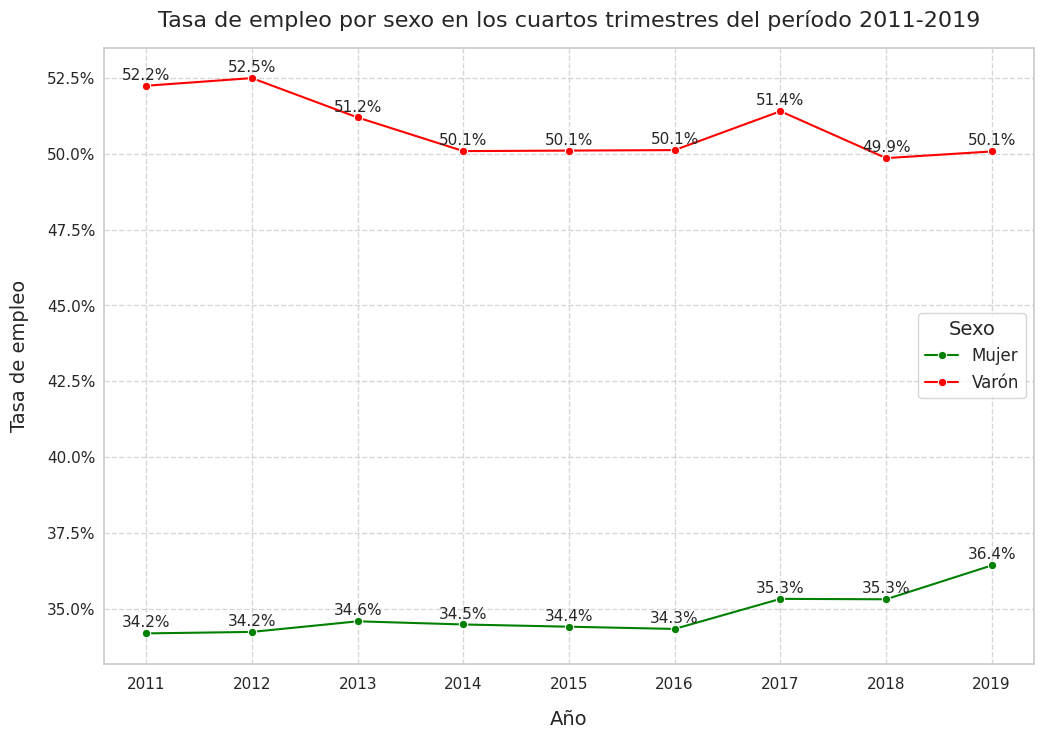

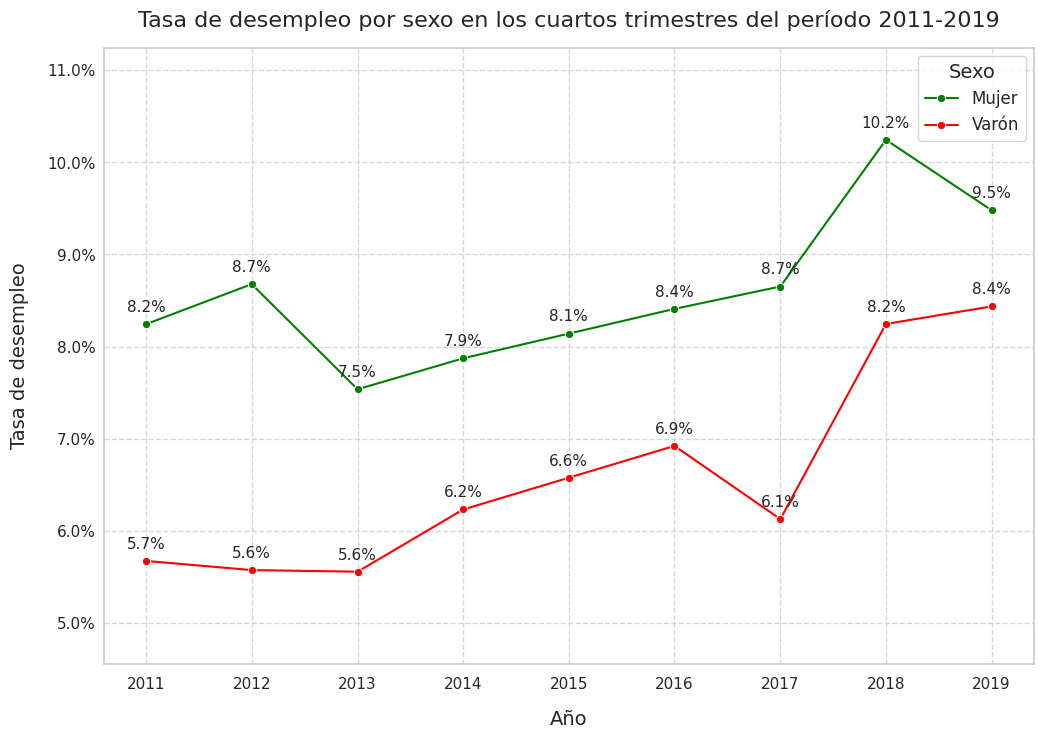

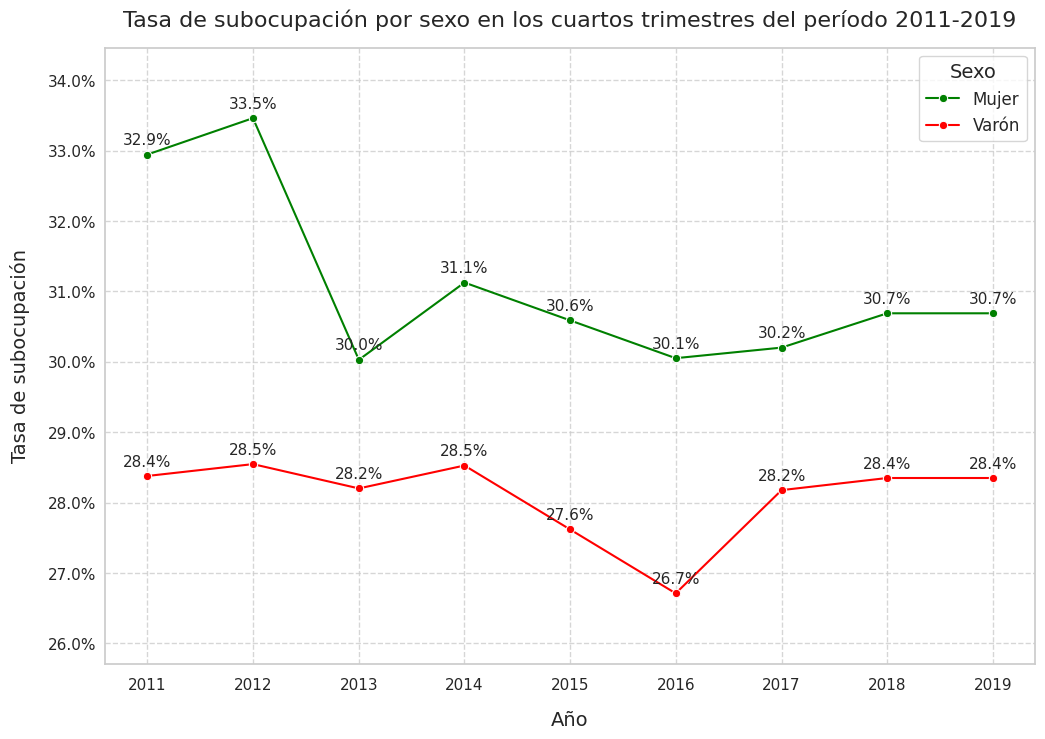

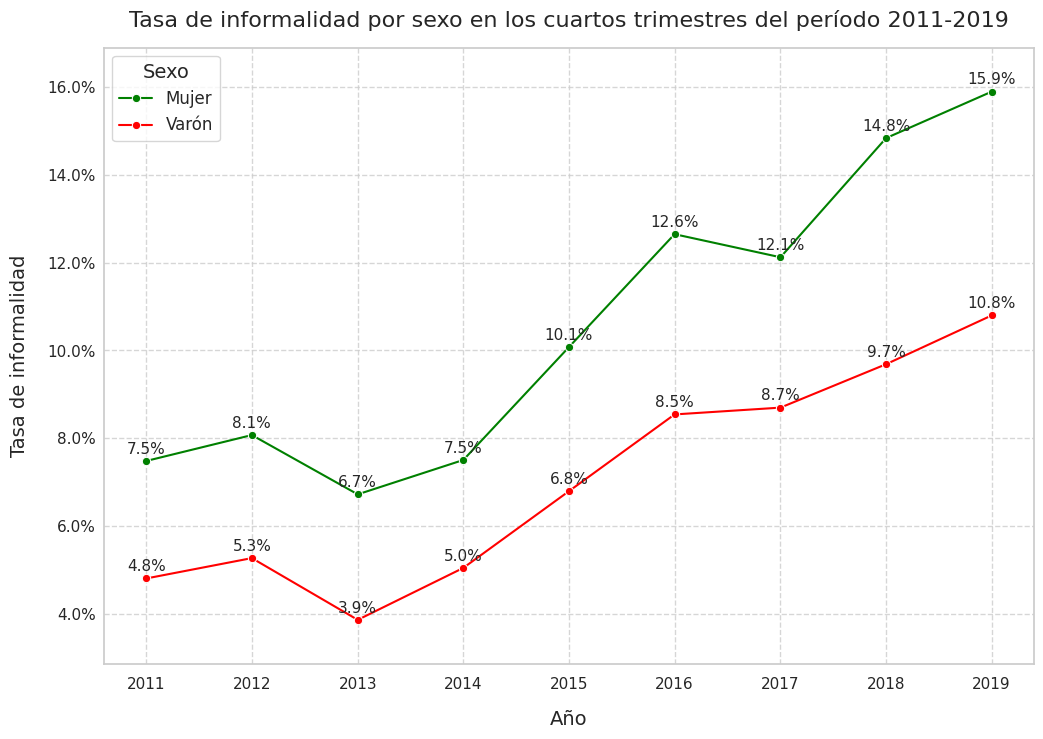

In [17]:
for columna in columnas:
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(12, 8))
    ax = sns.lineplot(x="Año", y=columna, hue="Sexo", data=sexo,
                      marker='o', palette={"Varón": "red", "Mujer": "green"})
    plt.title(f'Tasa de {nombre_columnas[columna].lower(
    )} por sexo en los cuartos trimestres del período 2011-2019', fontsize=16, pad=15)
    plt.grid(True, linestyle='--', alpha=0.8)

    ax.set_xlabel('Año', fontsize=14, labelpad=13)
    ax.set_ylabel(f'Tasa de {nombre_columnas[columna].lower()}', fontsize=14, labelpad=13)
    ax.set_ylim(min(sexo[f'{columna}']) - 1, max(sexo[f'{columna}']) + 1)

    ax.legend(title="Sexo", title_fontsize='14', fontsize='12')

    for x, y in zip(varon["Año"], varon[columna]):
        ax.text(x, y + 0.1, f'{y:.1f}%', ha='center', va='bottom', fontsize=11)

    for x, y in zip(mujer["Año"], mujer[columna]):
        ax.text(x, y + 0.1, f'{y:.1f}%', ha='center', va='bottom', fontsize=11)

    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1f}%'))
    ax.yaxis.set_tick_params(pad=0.05)

    plt.savefig(f"plots/eph/sexo/{nombre_columnas[columna]}_sexo.png")

## Por región

### Cargar datos y crear carpeta

In [10]:
file_path = "data/eph/Region_concatenado_interp.csv"
reg = pd.read_csv(file_path)
reg["Año"] = pd.to_datetime(reg["Año"], format="%Y")

DFs = {}
regiones = reg["REGION"].unique()
for region in regiones:
    region_df = reg[reg["REGION"] == region].copy()
    region_df["Año"] = pd.to_datetime(region_df["Año"], format="%Y")
    DFs[region] = region_df

columnas = list(reg.columns[2:-1])
nombre_columnas = ["Actividad", "Empleo",
                   "Desempleo", "Subocupación", "Informalidad"]
nombre_columnas = dict(zip(columnas, nombre_columnas))

os.makedirs("plots/eph/region", exist_ok=True)

### Gráficos de cada tasa por año y regíon

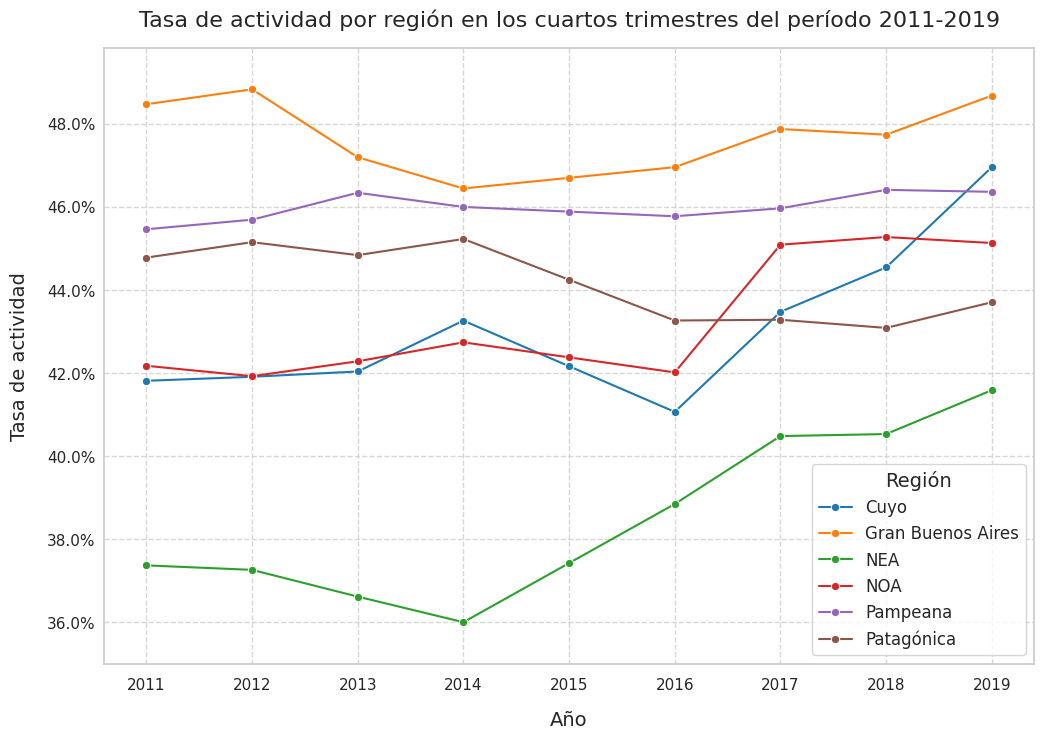

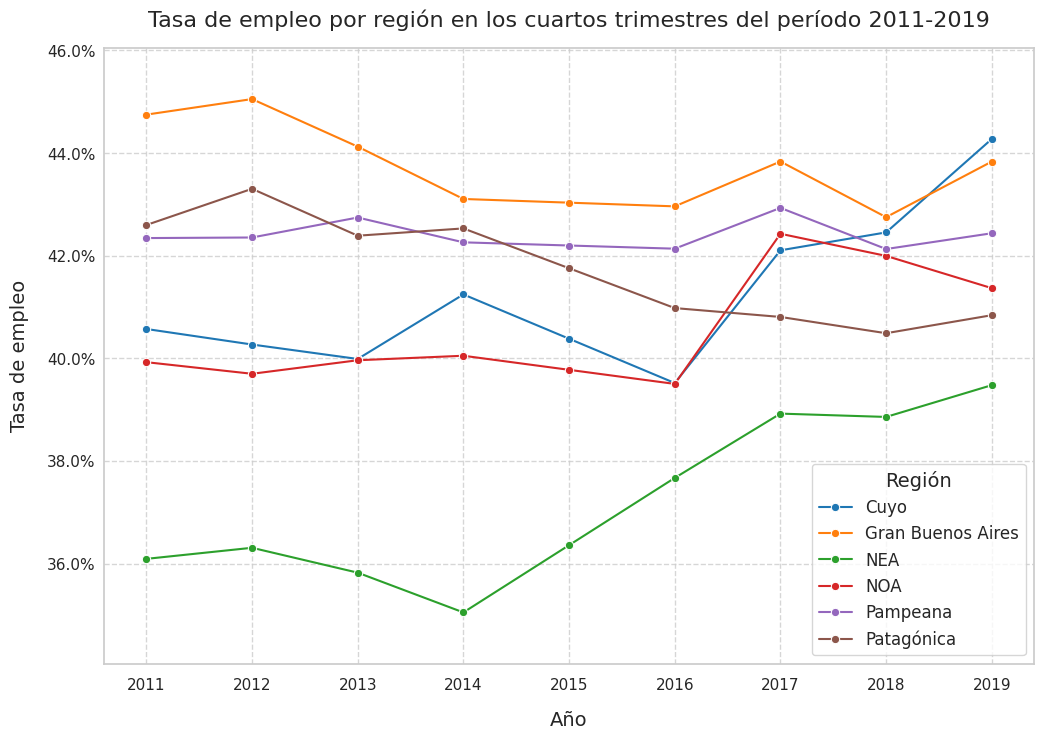

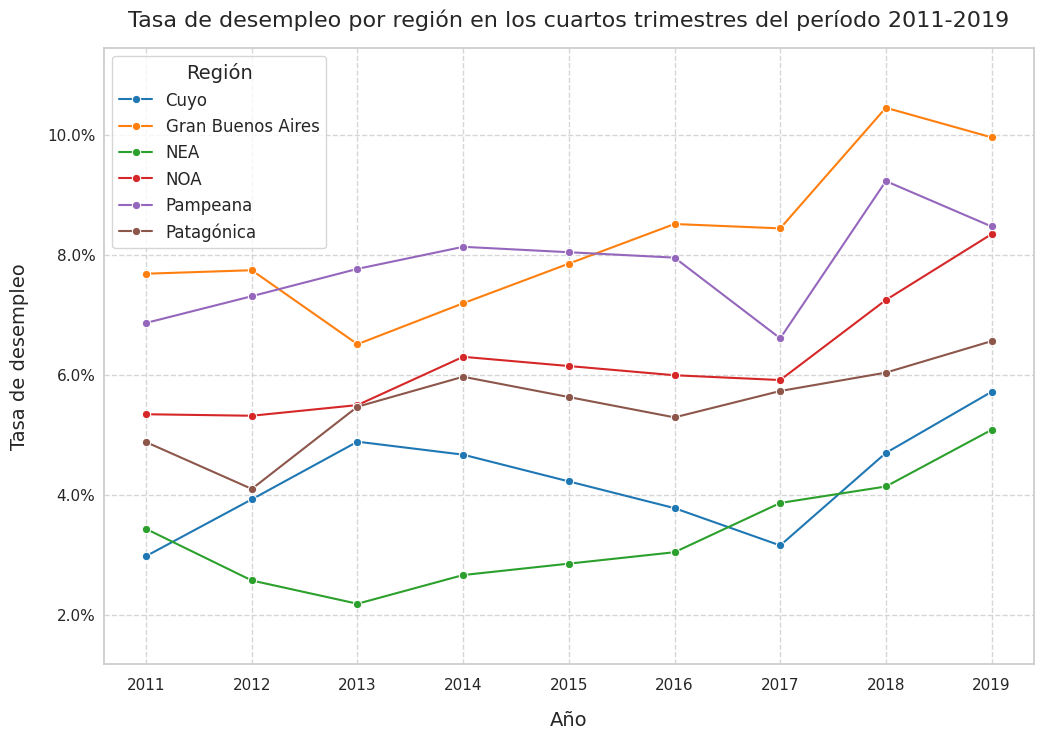

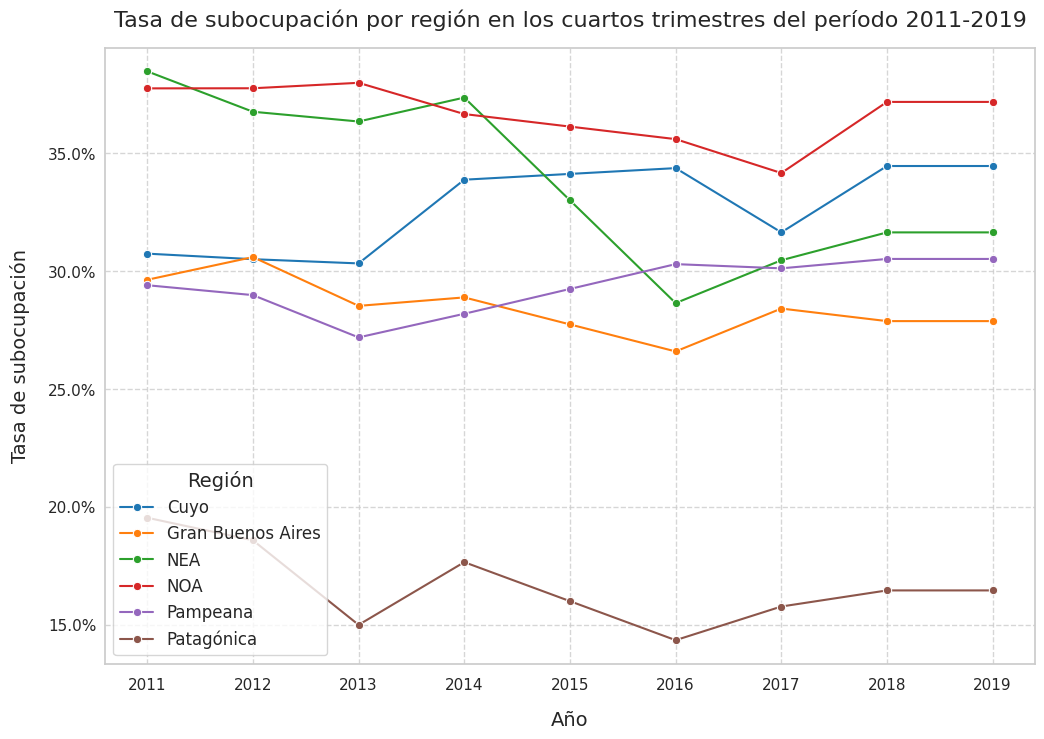

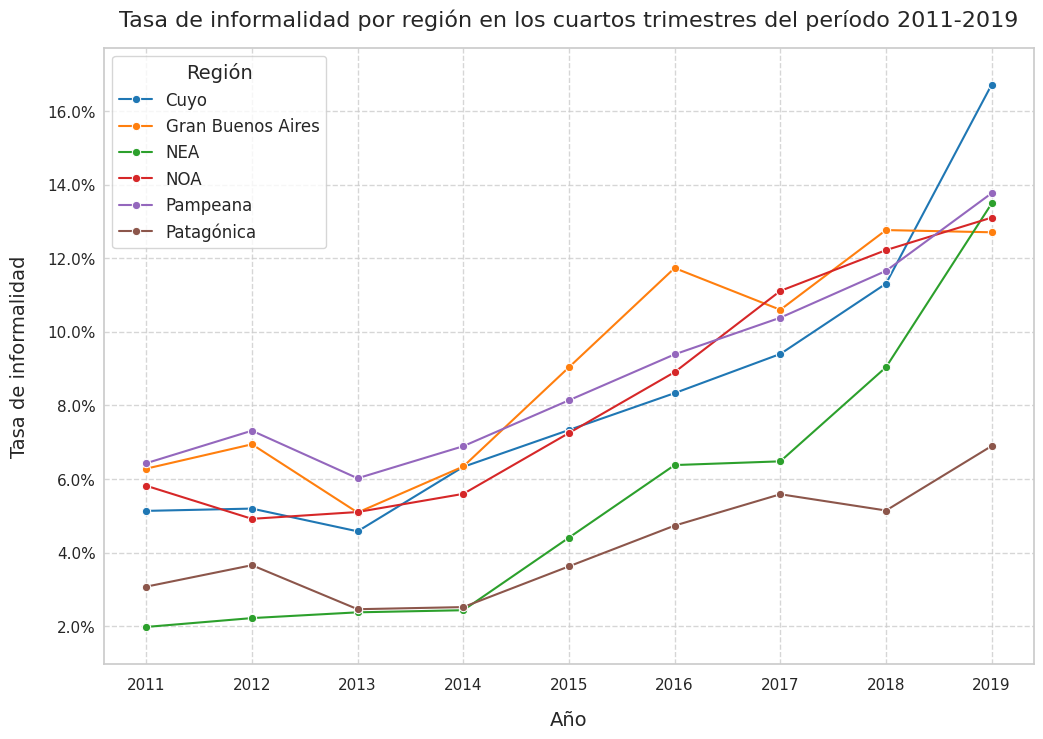

In [18]:
for columna in columnas:
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(12, 8))
    ax = sns.lineplot(x="Año", y=columna, hue="REGION", data=reg_interp,
                      marker='o', palette=sns.color_palette("tab10", len(regiones)))
    plt.title(f"Tasa de {nombre_columnas[columna].lower(
    )} por región en los cuartos trimestres del período 2011-2019", fontsize=16, pad=15)
    plt.grid(True, linestyle='--', alpha=0.8)

    ax.set_xlabel('Año', fontsize=14, labelpad=13)
    ax.set_ylabel(f'Tasa de {nombre_columnas[columna].lower()}', fontsize=14, labelpad=13)
    ax.set_ylim(min(reg_interp[f'{columna}']) - 1,
                max(reg_interp[f'{columna}']) + 1)

    ax.legend(title="Región", title_fontsize='14', fontsize='12')

    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1f}%'))
    ax.yaxis.set_tick_params(pad=0.05)

    plt.savefig(f"plots/eph/region/{nombre_columnas[columna]}_region.png")
    plt.show()